In [1]:
from google.colab import files
import zipfile
import io
import os

# This will prompt you to upload your zip file
uploaded = files.upload()

# Get the name of the uploaded file
zip_file_name = list(uploaded.keys())[0]

# Unzip the file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('medical_images')

# List the files in the extracted directory to make sure it worked
print(os.listdir('medical_images'))

Saving dataset.zip to dataset.zip
['dataset']


📂 Loading metadata...

🧪 Running for Patient ID: Patient_001
 Loading 66 images from datasets/synthetic_slices/Patient_001/CT/...


100%|██████████| 66/66 [00:00<00:00, 451.13it/s]


 ✅ Processed 66 slices from datasets/synthetic_slices/Patient_001/CT/
🔧 Enhancing with SRCNN...


100%|██████████| 66/66 [00:09<00:00,  6.82it/s]


📊 Extracting features...


100%|██████████| 66/66 [00:00<00:00, 609.38it/s]



📈 Validating enhancement...
✅ Saved metrics: validation_results/enhancement_metrics.csv
📦 Zipped results: validation_results/validation_output.zip

Average PSNR: 13.74
Average SSIM: 0.319


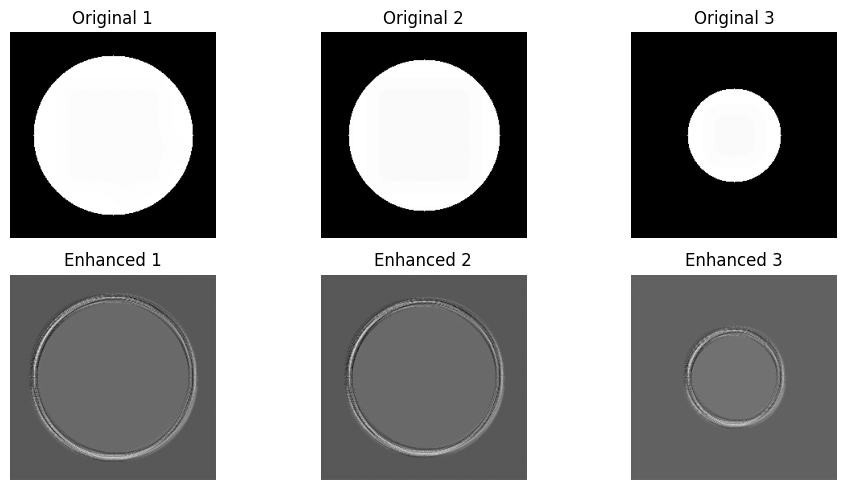

 Loading 84 images from datasets/synthetic_slices/Patient_001/MRI/...


100%|██████████| 84/84 [00:00<00:00, 701.83it/s]


 ✅ Processed 84 slices from datasets/synthetic_slices/Patient_001/MRI/
🔧 Enhancing with SRCNN...


100%|██████████| 84/84 [00:11<00:00,  7.23it/s]


📊 Extracting features...


100%|██████████| 84/84 [00:00<00:00, 617.33it/s]



📈 Validating enhancement...
✅ Saved metrics: validation_results/enhancement_metrics.csv
📦 Zipped results: validation_results/validation_output.zip

Average PSNR: 13.41
Average SSIM: 0.326


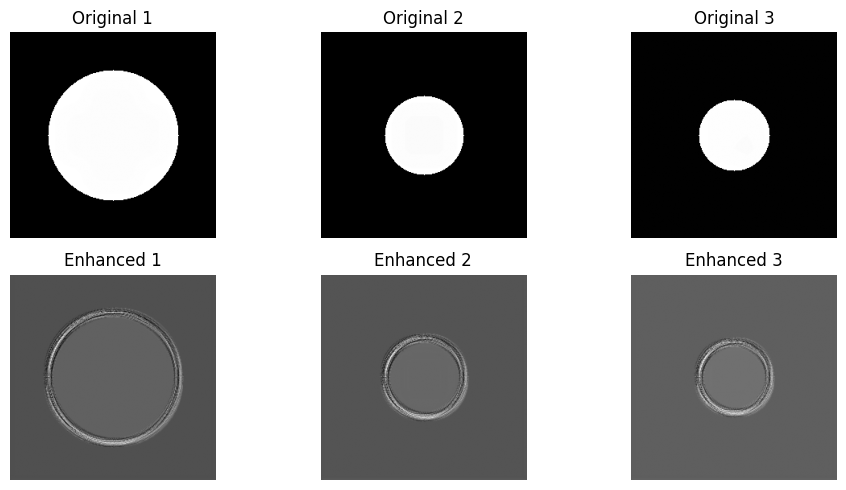


✅ Pipeline complete — enhancement, validation, and visualization done.


In [3]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from scipy.ndimage import generic_filter
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import warnings
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import zipfile

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================
#  STEP 1: MODEL DEFINITIONS
# ============================================================
def build_srcnn_model():
    input_img = Input(shape=(None, None, 1))
    x = Conv2D(64, (9, 9), padding='same', activation='relu')(input_img)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    output = Conv2D(1, (5, 5), padding='same', activation='linear')(x)
    model = Model(input_img, output)
    model.compile(optimizer='adam', loss='mse')
    return model


def build_classification_model(input_shape=(256, 256, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# ============================================================
#  STEP 2: IMAGE LOADING & PREPROCESSING
# ============================================================
def load_and_process_slices(folder_path, num_slices, target_size=(256, 256), enhance=True):
    processed_slices = []

    if not os.path.exists(folder_path):
        print(f" Folder path does not exist: {folder_path}")
        return processed_slices

    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.dcm'))]
    image_files.sort()

    if len(image_files) == 0:
        print(f" No valid image files found in: {folder_path}")
        return processed_slices

    print(f" Loading {len(image_files[:num_slices])} images from {folder_path}...")

    for image_file in tqdm(image_files[:num_slices]):
        try:
            img_path = os.path.join(folder_path, image_file)
            img = None

            if image_file.lower().endswith('.dcm'):
                try:
                    import pydicom
                    ds = pydicom.dcmread(img_path)
                    img = ds.pixel_array.astype(np.float32)
                    img = (img - img.min()) / (img.max() - img.min())
                except Exception as e:
                    print(f" DICOM error: {e}")
                    continue
            else:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    img = np.array(Image.open(img_path).convert('L'))

            img = cv2.resize(img, target_size)
            img = img.astype(np.float32) / 255.0

            if enhance:
                img = enhance_contrast(img)

            processed_slices.append(img)
        except Exception as e:
            print(f" Error processing {image_file}: {e}")

    print(f" ✅ Processed {len(processed_slices)} slices from {folder_path}")
    return processed_slices


def enhance_contrast(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply((image * 255).astype(np.uint8))
    return enhanced.astype(np.float32) / 255.0


# ============================================================
#  STEP 3: ENHANCEMENT & FEATURE EXTRACTION
# ============================================================
def enhance_with_srcnn(slices, srcnn_model):
    print("🔧 Enhancing with SRCNN...")
    enhanced_slices = []
    for slice in tqdm(slices):
        slice_expanded = np.expand_dims(slice, (0, -1))
        enhanced = srcnn_model.predict(slice_expanded, verbose=0)
        enhanced_slices.append(np.squeeze(enhanced))
    return enhanced_slices


def calculate_entropy(image):
    hist = np.histogram(image, bins=256, range=(0, 1))[0]
    hist = hist / hist.sum()
    return -np.sum(hist * np.log2(hist + 1e-10))


def extract_image_features(slices):
    print("📊 Extracting features...")
    features = []
    for i, img in enumerate(tqdm(slices)):
        features.append({
            'slice_number': i + 1,
            'mean': np.mean(img),
            'std': np.std(img),
            'entropy': calculate_entropy(img),
            'contrast': np.max(img) - np.min(img)
        })
    return features


# ============================================================
#  STEP 4: VALIDATION (PSNR & SSIM)
# ============================================================
def validate_enhancement(original_slices, enhanced_slices, output_dir="validation_results"):
    os.makedirs(output_dir, exist_ok=True)
    print("\n📈 Validating enhancement...")

    metrics = []
    for i, (orig, enh) in enumerate(zip(original_slices, enhanced_slices)):
        psnr_val = psnr(orig, enh, data_range=1.0)
        ssim_val = ssim(orig, enh, data_range=1.0)
        metrics.append({'Slice': i + 1, 'PSNR': psnr_val, 'SSIM': ssim_val})

    df = pd.DataFrame(metrics)
    csv_path = os.path.join(output_dir, "enhancement_metrics.csv")
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved metrics: {csv_path}")

    # ZIP all validation results
    zip_path = os.path.join(output_dir, "validation_output.zip")
    with zipfile.ZipFile(zip_path, "w") as zipf:
        zipf.write(csv_path, "enhancement_metrics.csv")
    print(f"📦 Zipped results: {zip_path}")

    print(f"\nAverage PSNR: {df['PSNR'].mean():.2f}")
    print(f"Average SSIM: {df['SSIM'].mean():.3f}")

    return df


# ============================================================
#  MAIN PIPELINE
# ============================================================
if __name__ == "__main__":
    print("📂 Loading metadata...")
    df = pd.read_csv("master_metadata.csv")

    sample_patient = df["Patient_ID"].iloc[0]
    patient_data = df[df["Patient_ID"] == sample_patient]

    print(f"\n🧪 Running for Patient ID: {sample_patient}")

    srcnn_model = build_srcnn_model()
    classification_model = build_classification_model()

    for _, row in patient_data.iterrows():
        modality = row["Modality"]
        folder_path = row["Folder_Path"]
        num_slices = row["Num_Slices"]

        slices = load_and_process_slices(folder_path, num_slices, enhance=True)
        enhanced_slices = enhance_with_srcnn(slices, srcnn_model)

        features = extract_image_features(enhanced_slices)
        metrics_df = validate_enhancement(slices, enhanced_slices)

        # Visual comparison
        plt.figure(figsize=(10, 5))
        for i in range(min(3, len(slices))):
            plt.subplot(2, 3, i + 1)
            plt.imshow(slices[i], cmap="gray")
            plt.title(f"Original {i+1}")
            plt.axis("off")

            plt.subplot(2, 3, i + 4)
            plt.imshow(enhanced_slices[i], cmap="gray")
            plt.title(f"Enhanced {i+1}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    print("\n✅ Pipeline complete — enhancement, validation, and visualization done.")


In [6]:
import os
import shutil
import pandas as pd

def finalize_validation_results(df, output_dir="validation_results"):
    """
    Save validation metrics and create a ZIP file for download.
    """
    if df is None or df.empty:
        print("⚠️ No validation data found to zip.")
        return

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save metrics CSV
    metrics_csv = os.path.join(output_dir, "validation_metrics.csv")
    df.to_csv(metrics_csv, index=False)
    print(f"✅ Validation metrics saved to: {metrics_csv}")

    # Remove existing ZIP if any
    zip_path = "validation_results.zip"
    if os.path.exists(zip_path):
        os.remove(zip_path)

    # Create ZIP archive
    shutil.make_archive("validation_results", "zip", output_dir)
    print(f"📦 Created ZIP file: {zip_path}")

    # Print summary stats
    print(f"\n📊 Average PSNR: {df['PSNR'].mean():.2f}")
    print(f"📊 Average SSIM: {df['SSIM'].mean():.3f}")

    return df
